# Solver and SLM Accuracy and Runtime Notebook

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
# from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
# import json


import sys
sys.path.append("./src")
from TOV_class import TOVsolver
from SLM import SLM
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()

In [3]:
error_threshold = 1e-6
modes = None  # set to `None` to auto-select modes 

# for Tabular:
EOS_modes = [[11, 13, 14, 14, 14],
             [14, 13, 10,  8, 14],
             [14, 14, 14,  8, 14]]
# for Quarkyonic:
# EOS_modes = [[13,  6,  9,  7,  9],
#              [13, 14,  9,  7, 14],
#              [12,  7,  6,  7, 14]]
# EOS_modes = [[None] * 5, [None] * 5, [None] * 5]

In [4]:
eos_path = "../EOS_Data/"
# eos_path = "./../EOS_files/QEOS/"

# check the accuracy and runtimes with the tabular EOSs (5 of them)
files_to_check = ["BL_eos.table", 
                  "FSUGarnetNStarEOSA.txt", 
                  "sorted_Sly4.dat", 
                  "DS_CMF_eos.table", 
                  "apr_eos.table"]
# files_to_check = ["EOS_Quarkyonia_0.26_300.00.txt",
#                   "EOS_Quarkyonia_0.12_352.63.txt",
#                   "EOS_Quarkyonia_0.23_384.21.txt",
#                   "EOS_Quarkyonia_0.14_436.84.txt",
#                   "EOS_Quarkyonia_0.28_500.00.txt"]

eos_names = ["BL", "FSU Garnet", "SLy4", "DSCMF", "APR"]
# eos_names = ["300.00, 0.26", "352.63, 0.12", "384.21, 0.23", "436.84, 0.14", "500.00, 0.28"]

In [5]:
sol_pts = 5000  # 5000  # number of points used per iteration for non solve_ivp solvers
number_of_solves = 1  # make this more for checking the runtimes !

# these empty lists will get filled with their corresponding runtimes per solve (size = `number_of_solves * 5`)
HF_runtimes = {"exact": [],
               "RK4": [],
               "RK2": [],
               "euler": []}
SLM_runtimes = {"exact": [],
                "RK4": [],
                "RK2": [],
                "euler": []}

In [6]:
mode_index = 0

## Calculate Exact (Adaptive) Solver

This uses `solve_ivp`

In [7]:
# tol = 3e-14

# # store the solutions per EOS
# exact_HF_results = {}
# exact_SLM_results = {}
# for i in np.arange(number_of_solves):
#     for i, file in enumerate(files_to_check):
#         eos_name = eos_names[i]
#         file_path = f"{eos_path}{file}"
#         # if not os.path.isfile(file_path):
#         #     print(f"\n\nSkipping {eos_name}: {file_path} not found.")
#         #     continue
#         print(f"\n\nChecking {eos_name}: ", end="")
        
#         # some solve_ivp methods: "RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"
#         # "Radau" is particularly good for stick ODEs (like these). But RK45 should also be good too.
#         tov_exact = TOVsolver(file_path, tidal=True, solver="RK45", solve_ivp_kwargs={"method": "RK45", 
#                                                                                            "atol": tol, 
#                                                                                            "rtol": tol})
        
        
#         # time the HF solution
#         HF_start_time = time.time()
#         tov_exact.tov_routine(verbose=False, write_to_file=False)  # HF solution
#         HF_end_time = time.time()
#         HF_runtime = HF_end_time - HF_start_time
#         HF_runtimes["exact"].append(HF_runtime)
        
#         # store data
#         rad = tov_exact.total_radius
#         pres = tov_exact.total_pres_central
#         mass = tov_exact.total_mass
#         tidal = tov_exact.k2

#         X = np.asarray([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)

#         linT = np.arange(len(pres))
#         dt = (linT[-1] - linT[0]) / len(linT)  # time step for SLM
#         print("dt:", dt)
#         # X_list = [np.log(r_orig), np.log(p_orig), np.log(m_orig)]
#         # if tidal is True:
#         #     X_list.append(np.log(tidal_def))
#         # X = np.asarray(X_list, dtype=np.float64)

#         SLM_start_time = time.time()
#         SLM_result = SLM(X, dt, error_threshold=error_threshold, modes=modes)
#         Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
#         SLM_end_time = time.time()
#         SLM_runtime = SLM_end_time - SLM_start_time
        
#         SLM_runtimes["exact"].append(SLM_runtime)

#         exact_HF_results[eos_name] = np.exp(X)
#         exact_SLM_results[eos_name] = np.exp(X_SLM)

#         print(f"HF solved in {HF_runtime:.4} seconds.")
#         print(f"SLM solved in {SLM_runtime:.4} seconds.")
#         print(f"speedup: {HF_runtime / SLM_runtime:.2}")


In [8]:
# fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))

# ax[0].set_title("Visualizing Exact MR Curves")
# for eos in eos_names:
#     ax[0].scatter(exact_HF_results[eos][0], exact_HF_results[eos][2], 
#                 alpha=0.7, label=f"{eos} data")
#     ax[0].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][2], 
#              alpha=0.7, linewidth=3, label=f"{eos} SLM")
# ax[0].legend()


# ax[1].set_title("Visualizing Exact PR Curves")
# for eos in eos_names:
#     ax[1].scatter(exact_HF_results[eos][0], exact_HF_results[eos][1], 
#                 alpha=0.7, label=f"{eos} data")
#     ax[1].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][1], 
#              alpha=0.7, linewidth=3, label=f"{eos} SLM")
# ax[1].set_yscale("log")
# ax[1].legend()

# ax[2].set_title("Visualizing Exact k2R Curves")
# for eos in eos_names:
#     ax[2].scatter(exact_HF_results[eos][0], exact_HF_results[eos][3], 
#                 alpha=0.7, label=f"{eos} data")
#     ax[2].plot(exact_SLM_results[eos][0], exact_SLM_results[eos][3], 
#              alpha=0.7, linewidth=3, label=f"{eos} SLM")
# ax[2].legend()

# plt.show()

## Check RK4 solver

In [9]:
# store the solutions per EOS
RK4_HF_results = {}
RK4_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK4 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK4", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK4.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK4"].append(HF_runtime)
        
        # store data
        rad = tov_RK4.total_radius
        pres = tov_RK4.total_pres_central
        mass = tov_RK4.total_mass
        tidal = tov_RK4.k2


        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        nan_indices = np.argwhere(np.isnan(X))
        if nan_indices.shape[0] > 0:
            nan_indices = nan_indices[:, 1]
            print("Filtered indices: ", end="")
            print(nan_indices)
            # this is a super slow way to do this
            filtered_data = np.zeros((X.shape[0], 
                                     X.shape[1] - len(nan_indices)), 
                                     dtype=np.float64)
            qq = 0
            for j in np.arange(X.shape[1]):
                if j not in nan_indices:
                    filtered_data[:, qq] = X[:, j]
                    qq += 1
        else:
            filtered_data = X
        
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        SLM_result = SLM(filtered_data, dt, error_threshold=error_threshold, 
                         modes=EOS_modes[mode_index][i])
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["RK4"].append(SLM_runtime)

        RK4_HF_results[eos_name] = np.exp(X)
        RK4_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking BL: Woo it worked!
Max mass:  2.082888 Radius:  10.347596 Central pressure:  753.464508
HF solved in 22.54 seconds.
SLM solved in 0.0004742 seconds.
speedup: 4.8e+04


Checking FSU Garnet: Woo it worked!
Max mass:  2.066405 Radius:  11.600631 Central pressure:  353.016547
HF solved in 22.63 seconds.
SLM solved in 0.0004508 seconds.
speedup: 5e+04


Checking SLy4: Woo it worked!
Max mass:  2.067066 Radius:  10.032662 Central pressure:  867.67565
HF solved in 22.52 seconds.
SLM solved in 0.000458 seconds.
speedup: 4.9e+04


Checking DSCMF: Woo it worked!
Max mass:  2.022854 Radius:  11.808354 Central pressure:  315.027053
HF solved in 22.51 seconds.
SLM solved in 0.000493 seconds.
speedup: 4.6e+04


Checking APR: Woo it worked!
Max mass:  2.192606 Radius:  9.985757 Central pressure:  1013.27043
HF solved in 22.51 seconds.
SLM solved in 0.000493 seconds.
speedup: 4.6e+04


/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


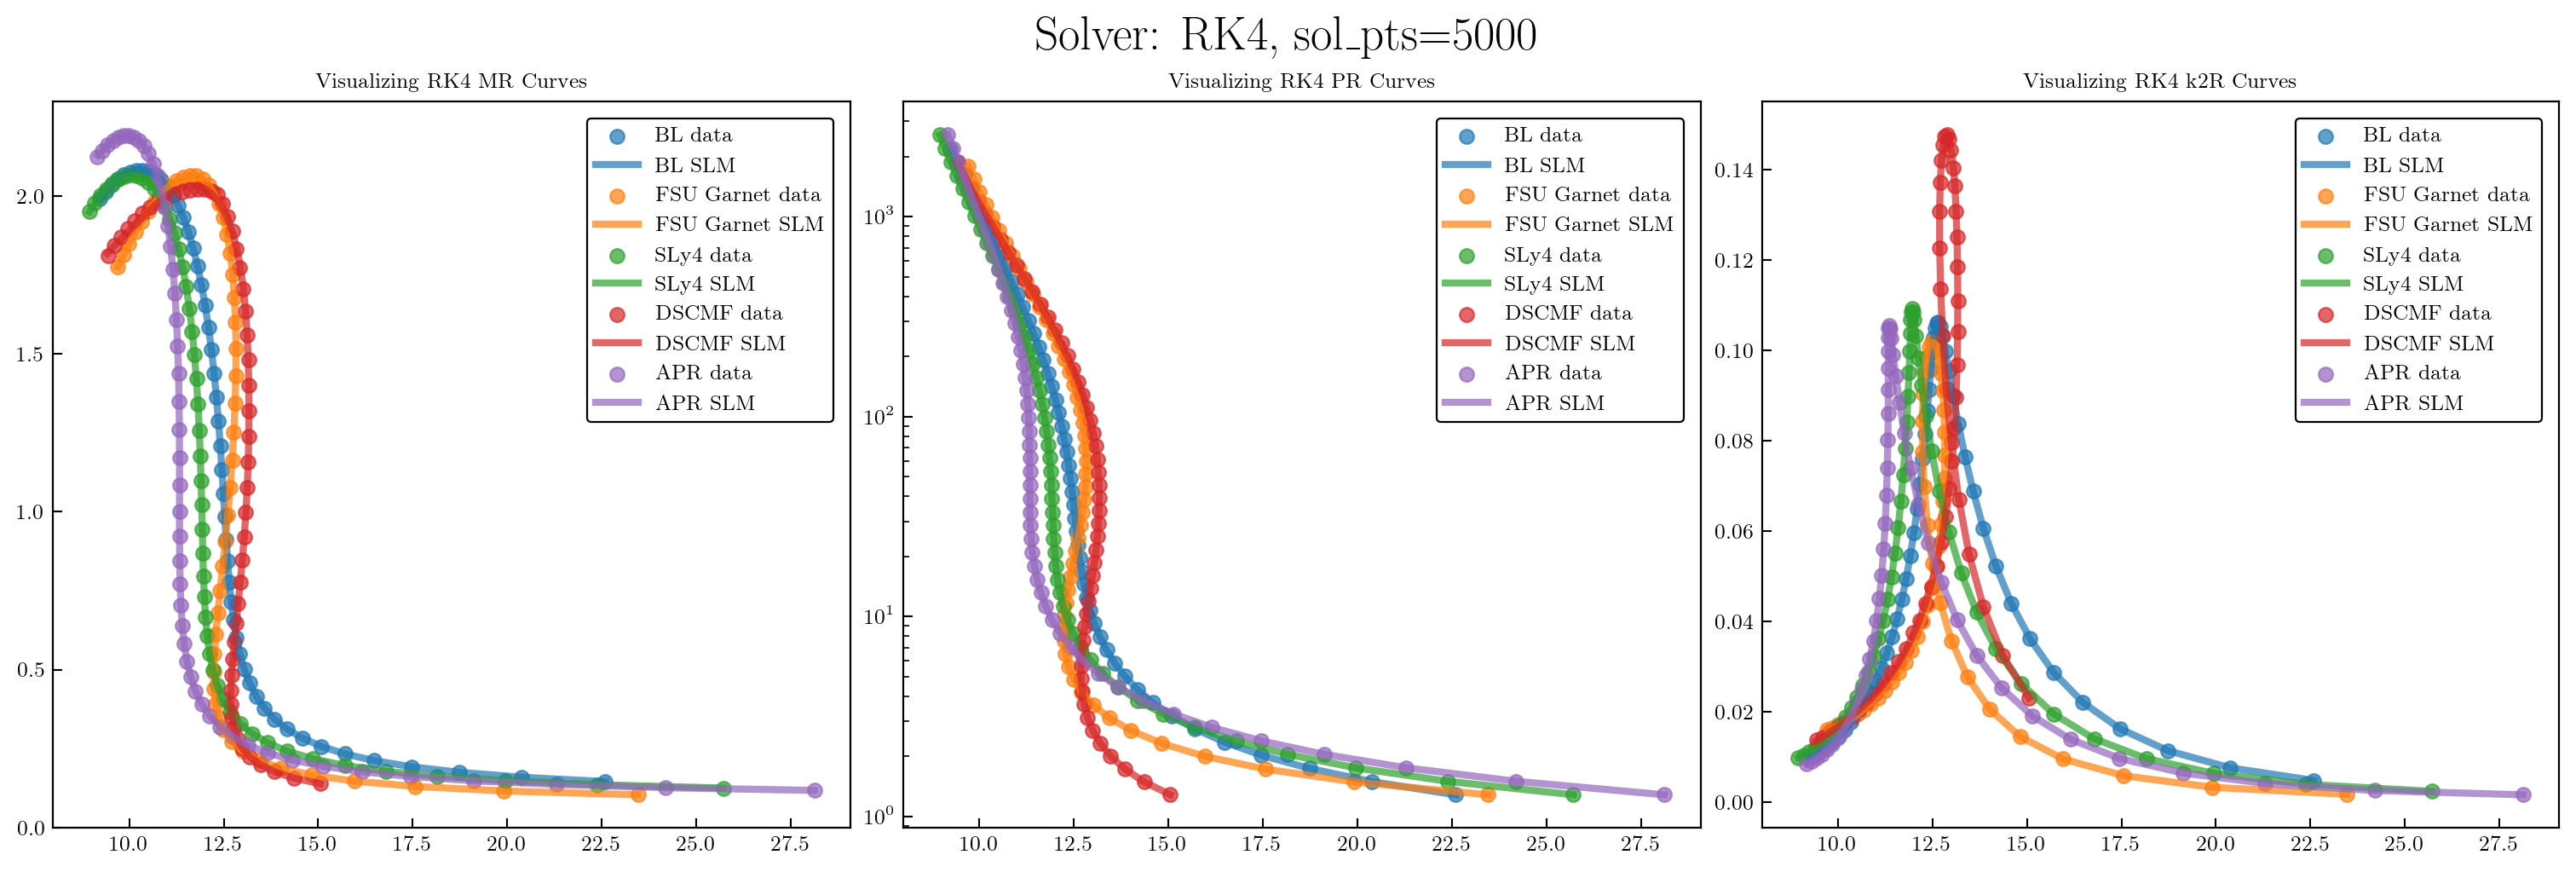

In [10]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))
plt.suptitle(f"Solver: RK4, sol_pts={sol_pts}", fontsize=20)

ax[0].set_title("Visualizing RK4 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK4 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing RK4 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK4_HF_results[eos][0], RK4_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK4_SLM_results[eos][0], RK4_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Check RK2 Solver

In [11]:
mode_index += 1

In [12]:
# store the solutions per EOS
RK2_HF_results = {}
RK2_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_RK2 = TOVsolver(f"{eos_path}{file}", tidal=True, solver="RK2", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_RK2.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["RK2"].append(HF_runtime)
        
        # store data
        rad = tov_RK2.total_radius
        pres = tov_RK2.total_pres_central
        mass = tov_RK2.total_mass
        tidal = tov_RK2.k2

        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        nan_indices = np.argwhere(np.isnan(X))
        if nan_indices.shape[0] > 0:
            nan_indices = nan_indices[:, 1]
            print("Filtered nan indices: ", end="")
            print(nan_indices)
            # this is a super slow way to do this
            filtered_data = np.zeros((X.shape[0], 
                                     X.shape[1] - len(nan_indices)), 
                                     dtype=np.float64)
            qq = 0
            for j in np.arange(X.shape[1]):
                if j not in nan_indices:
                    filtered_data[:, qq] = X[:, j]
                    qq += 1
        else:
            filtered_data = X
        
        inf_indices = np.argwhere(np.isinf(filtered_data))
        if inf_indices.shape[0] > 0:
            inf_indices = inf_indices[:, 1]
            print("Filtered inf indices: ", end="")
            print(inf_indices)
            # this is a super slow way to do this
            filtered_data = np.zeros((filtered_data.shape[0], 
                                     filtered_data.shape[1] - len(inf_indices)), 
                                     dtype=np.float64)
            qq = 0
            for j in np.arange(filtered_data.shape[1]):
                if j not in inf_indices:
                    filtered_data[:, qq] = filtered_data[:, j]
                    qq += 1
        
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        SLM_result = SLM(filtered_data, dt, error_threshold=error_threshold, 
                         modes=EOS_modes[mode_index][i])
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        SLM_runtimes["RK2"].append(SLM_runtime)

        RK2_HF_results[eos_name] = np.exp(X)
        RK2_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking BL: Woo it worked!
Max mass:  2.082891 Radius:  10.360997 Central pressure:  753.464508
HF solved in 11.14 seconds.
SLM solved in 0.0005572 seconds.
speedup: 2e+04


Checking FSU Garnet: Woo it worked!
Max mass:  2.066407 Radius:  11.607332 Central pressure:  353.016547
HF solved in 11.1 seconds.
SLM solved in 0.0004551 seconds.
speedup: 2.4e+04


Checking SLy4: Woo it worked!
Max mass:  2.067068 Radius:  10.046063 Central pressure:  867.67565
HF solved in 11.07 seconds.
SLM solved in 0.0004592 seconds.
speedup: 2.4e+04


Checking DSCMF: Woo it worked!
Max mass:  2.022856 Radius:  11.815054 Central pressure:  315.027053
HF solved in 11.54 seconds.
SLM solved in 0.000397 seconds.
speedup: 2.9e+04


Checking APR: Woo it worked!
Max mass:  2.192609 Radius:  9.999158 Central pressure:  1013.27043
HF solved in 11.36 seconds.
SLM solved in 0.000555 seconds.
speedup: 2e+04


/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/joshuamaldonado/Documents/GitHub/SLM/venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


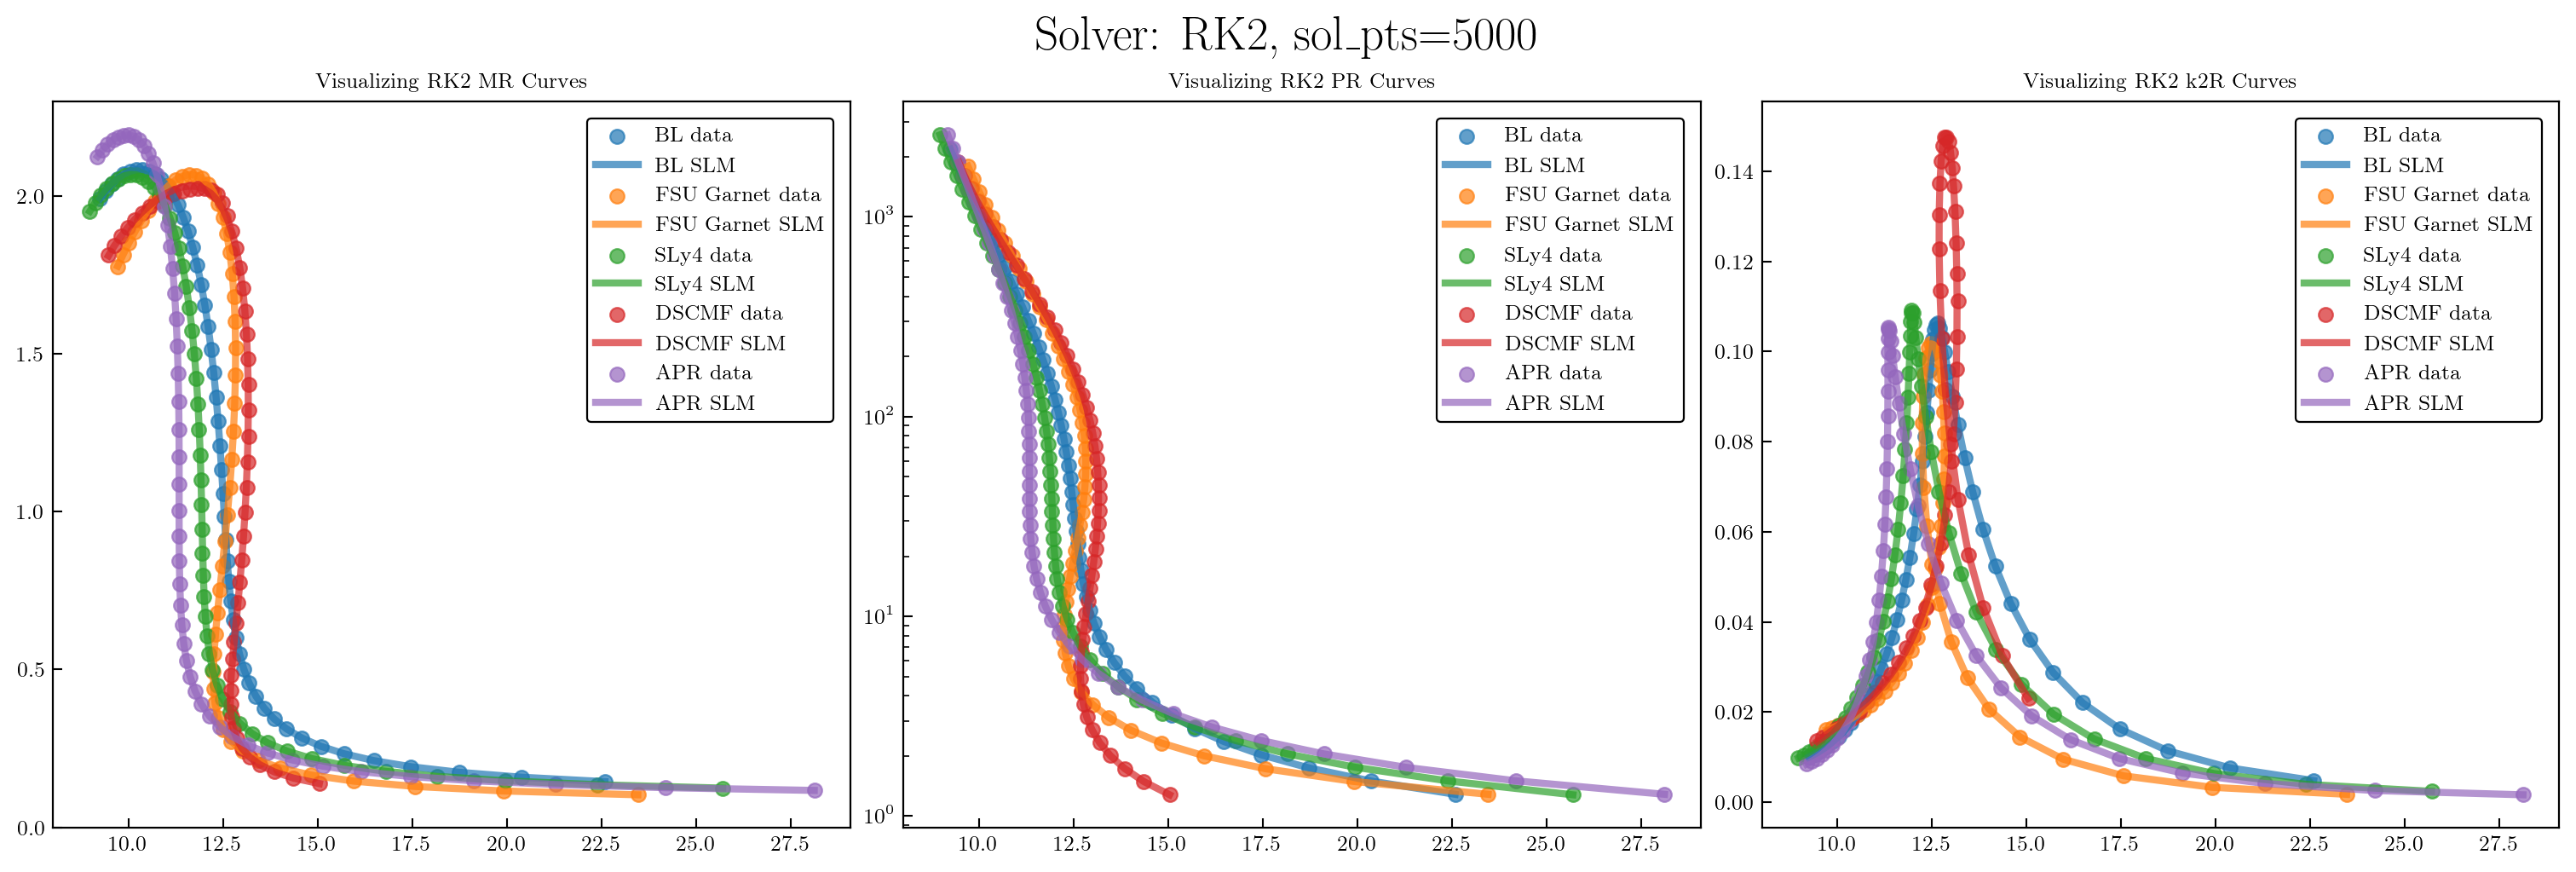

In [13]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))
plt.suptitle(f"Solver: RK2, sol_pts={sol_pts}", fontsize=20)

ax[0].set_title("Visualizing RK2 MR Curves")
for eos in eos_names:
    ax[0].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing RK2 PR Curves")
for eos in eos_names:
    ax[1].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing RK2 k2R Curves")
for eos in eos_names:
    ax[2].scatter(RK2_HF_results[eos][0], RK2_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(RK2_SLM_results[eos][0], RK2_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

# Check Euler Solver

In [14]:
mode_index += 1

In [15]:
# store the solutions per EOS
euler_HF_results = {}
euler_SLM_results = {}
for i in np.arange(number_of_solves):
    for i, file in enumerate(files_to_check):
        eos_name = eos_names[i]
        print(f"\n\nChecking {eos_name}: ", end="")
        
        tov_euler = TOVsolver(f"{eos_path}{file}", tidal=True, solver="euler", sol_pts=sol_pts)
        
        
        # time the HF solution
        HF_start_time = time.time()
        tov_euler.tov_routine(verbose=False, write_to_file=False)  # HF solution
        HF_end_time = time.time()
        HF_runtime = HF_end_time - HF_start_time
        HF_runtimes["euler"].append(HF_runtime)
        
        # store data
        rad = tov_euler.total_radius
        pres = tov_euler.total_pres_central
        mass = tov_euler.total_mass
        tidal = tov_euler.k2

        X = np.array([np.log(rad), np.log(pres), np.log(mass), np.log(tidal)], dtype=np.float64)
        nan_indices = np.argwhere(np.isnan(X))
        if nan_indices.shape[0] > 0:
            nan_indices = nan_indices[:, 1]
            print("Filtered indices: ", end="")
            print(nan_indices)
            # this is a super slow way to do this
            filtered_data = np.zeros((X.shape[0], 
                                     X.shape[1] - len(nan_indices)), 
                                     dtype=np.float64)
            qq = 0
            for j in np.arange(X.shape[1]):
                if j not in nan_indices:
                    filtered_data[:, qq] = X[:, j]
                    qq += 1
        else:
            filtered_data = X
        
        linT = np.arange(len(pres))
        dt = (linT[-1] - linT[0]) / len(linT)
        
        SLM_start_time = time.time()
        SLM_result = SLM(filtered_data, dt, error_threshold=error_threshold, 
                         modes=EOS_modes[mode_index][i])
        Phi, Omega, lambdaVals, b, X_SLM, sVal, rVal = SLM_result
        SLM_end_time = time.time()
        SLM_runtime = SLM_end_time - SLM_start_time
        
        SLM_runtimes["euler"].append(SLM_runtime)
        
        euler_HF_results[eos_name] = np.exp(X)
        euler_SLM_results[eos_name] = np.exp(X_SLM)

        print(f"HF solved in {HF_runtime:.4} seconds.")
        print(f"SLM solved in {SLM_runtime:.4} seconds.")
        print(f"speedup: {HF_runtime / SLM_runtime:.2}")
#




Checking BL: Woo it worked!
Max mass:  2.082416 Radius:  10.29399 Central pressure:  753.464508
HF solved in 5.54 seconds.
SLM solved in 0.0004621 seconds.
speedup: 1.2e+04


Checking FSU Garnet: Woo it worked!
Max mass:  2.066143 Radius:  11.547025 Central pressure:  353.016547
HF solved in 5.551 seconds.
SLM solved in 0.0005269 seconds.
speedup: 1.1e+04


Checking SLy4: Woo it worked!
Max mass:  2.066555 Radius:  9.979056 Central pressure:  867.67565
HF solved in 5.748 seconds.
SLM solved in 0.000483 seconds.
speedup: 1.2e+04


Checking DSCMF: Woo it worked!
Max mass:  2.022538 Radius:  11.754748 Central pressure:  315.027053
HF solved in 5.548 seconds.
SLM solved in 0.0003998 seconds.
speedup: 1.4e+04


Checking APR: Woo it worked!
Max mass:  2.192236 Radius:  9.932151 Central pressure:  1013.27043
HF solved in 5.542 seconds.
SLM solved in 0.0004807 seconds.
speedup: 1.2e+04


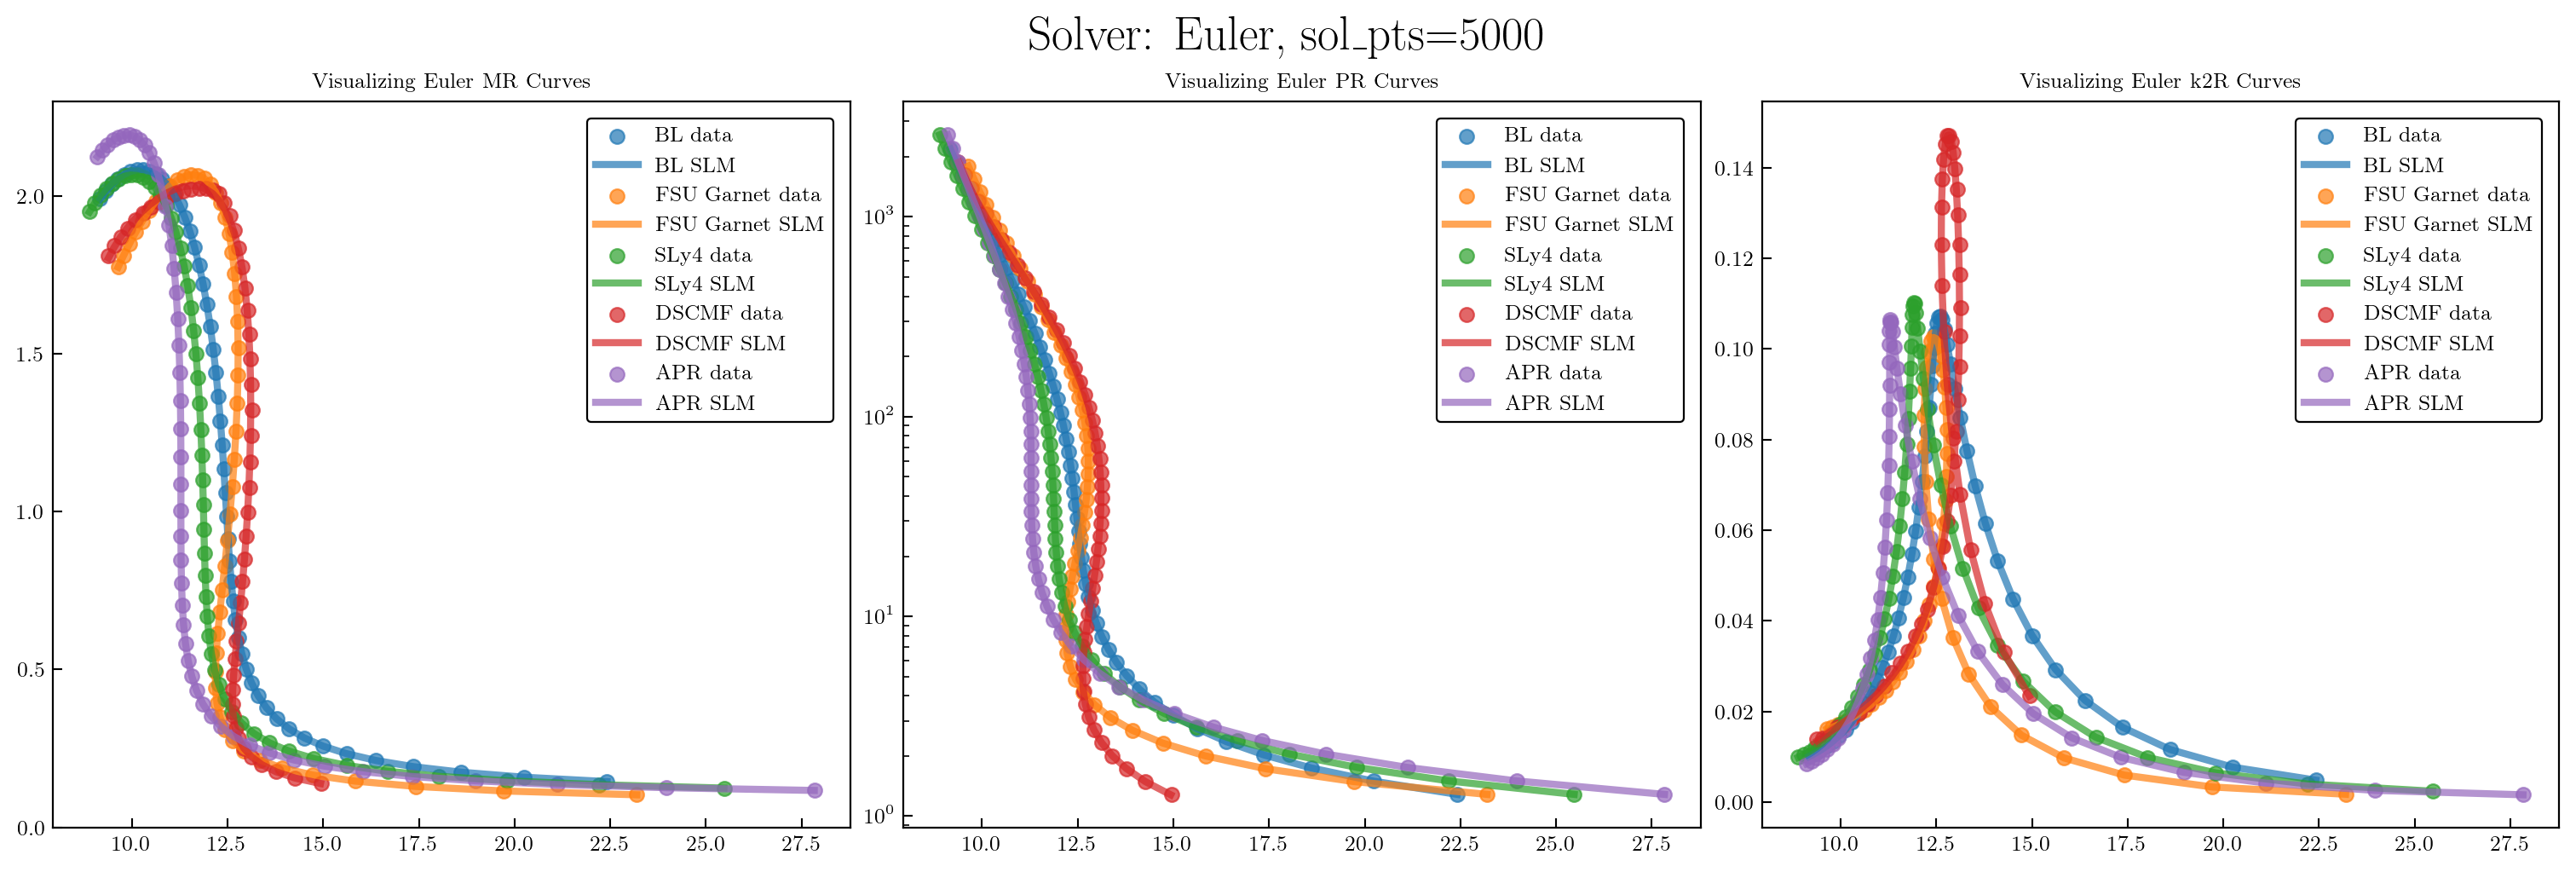

In [16]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(15, 5))
plt.suptitle(f"Solver: Euler, sol_pts={sol_pts}", fontsize=20)

ax[0].set_title("Visualizing Euler MR Curves")
for eos in eos_names:
    ax[0].scatter(euler_HF_results[eos][0], euler_HF_results[eos][2], 
                alpha=0.7, label=f"{eos} data")
    ax[0].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][2], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[0].legend()


ax[1].set_title("Visualizing Euler PR Curves")
for eos in eos_names:
    ax[1].scatter(euler_HF_results[eos][0], euler_HF_results[eos][1], 
                alpha=0.7, label=f"{eos} data")
    ax[1].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][1], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[1].set_yscale("log")
ax[1].legend()

ax[2].set_title("Visualizing Euler k2R Curves")
for eos in eos_names:
    ax[2].scatter(euler_HF_results[eos][0], euler_HF_results[eos][3], 
                alpha=0.7, label=f"{eos} data")
    ax[2].plot(euler_SLM_results[eos][0], euler_SLM_results[eos][3], 
             alpha=0.7, linewidth=3, label=f"{eos} SLM")
ax[2].legend()

plt.show()

## Nice! Now look at errors

I'm not totally sure the best way to go about this. So I'll look at where the peak is on the MR curve since that's how we did the errors on the table originally.

In [17]:
def the_good_interpolator(x_tov, y_tov, x_dmd):
    # Create a normalized parameter t that corresponds to the original x values
    t_original = np.linspace(0, 1, num=len(x_tov))
    
    # Create cubic splines for original x and y
    cs_x = CubicSpline(t_original, x_tov, bc_type='natural')
    cs_y = CubicSpline(t_original, y_tov, bc_type='natural')
    
    # Create a new parameter t for the new x-values
    t_new = np.linspace(0, 1, num=len(x_dmd))
    
    # Interpolate to find the corresponding y-values for the new x-values
    y_new = cs_y(t_new)
    
    return x_dmd, y_new

def percent_error(HF, SLM):
    try:
        error = 100 * np.abs(HF - SLM) / HF
    except:
        error = np.nan
    return error

In [18]:
HF_runtimes

{'exact': [],
 'RK4': [22.535768270492554,
  22.628698110580444,
  22.5191068649292,
  22.507125854492188,
  22.514636993408203],
 'RK2': [11.144822120666504,
  11.104859113693237,
  11.074678897857666,
  11.541967868804932,
  11.361797094345093],
 'euler': [5.540453195571899,
  5.551023960113525,
  5.747549295425415,
  5.547616004943848,
  5.542062044143677]}

In [27]:
errors = {}  # for storing all errors
exact_HF = []  # for comparing HF solvers to the exact results

rad_HF = {}
mass_HF = {}
rad_SLM = {}
mass_SLM = {}

solvers = ["RK4", "RK2", "euler"]
for solver in solvers:
    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        HF = eval(f"{solver}_HF_results[\"{eos_name}\"]")
        SLM_data = eval(f"{solver}_SLM_results[\"{eos_name}\"]")
        
        # select max point on MR curve
        # for HF
        HF_max_index = np.where(HF[2] == np.max(HF[2]))[0][0]  # grab index the maximum mass
        HF_max_rad = HF[0][HF_max_index]
        HF_max_mass = HF[2][HF_max_index]
        rad_HF[f"{eos_name} {solver}"] = HF_max_rad
        mass_HF[f"{eos_name} {solver}"] = HF_max_mass
        # for SLM
        SLM_max_index = np.where(SLM_data[2] == np.max(SLM_data[2]))[0][0]  # grab index the maximum mass
        SLM_max_rad = SLM_data[0][SLM_max_index].real
        SLM_max_mass = SLM_data[2][SLM_max_index].real
        rad_SLM[f"{eos_name} {solver}"] = SLM_max_rad
        mass_SLM[f"{eos_name} {solver}"] = SLM_max_mass
        
        # store the exact results for comparing to the other solvers
        # if (solver == "exact"):
        #     exact_HF.append([HF_max_rad, HF_max_mass])
        # else:
        #     errors[f"{eos_name} {solver} HF rad"] = percent_error(exact_HF[i][0], HF_max_rad)
        #     errors[f"{eos_name} {solver} HF mass"] = percent_error(exact_HF[i][1], HF_max_mass)
        
        # compare SLM to it's corresponding HF solver
        errors[f"{eos_name} {solver} SLM rad"] = percent_error(HF_max_rad, SLM_max_rad)
        errors[f"{eos_name} {solver} SLM mass"] = percent_error(HF_max_mass, SLM_max_mass)


# print results
for i, eos in enumerate(files_to_check):
    eos_name = eos_names[i]
    print(f"{eos_name} EOS:                 <----")
    for solver in solvers:
        # if solver == "RK4":
        #     print("!!!\n")
        if (solver != "exact"):
            print(f"{solver} HF result: ")
            print(f"      mass = {np.round(mass_HF[f"{eos_name} {solver}"], 3)}")
            print(f"    radius = {np.round(rad_HF[f"{eos_name} {solver}"], 3)}")
            print(f"{solver} SLM result: ")
            print(f"      mass = {np.round(mass_SLM[f"{eos_name} {solver}"], 3)}")
            print(f"    radius = {np.round(rad_SLM[f"{eos_name} {solver}"], 3)}")
            
            # print(f"{solver} HF  error:")
            # print(f"    mass={np.round(errors[f"{eos_name} {solver} HF mass"], 2)}")
            # print(f"    rad={np.round(errors[f"{eos_name} {solver} HF rad"], 2)}")
            print(f"{solver} SLM error:")
            print(f"    mass={np.round(errors[f"{eos_name} {solver} SLM mass"], 2)}")
            print(f"    rad={np.round(errors[f"{eos_name} {solver} SLM rad"], 2)}")
        else:
            print(f"{solver} SLM error:")
            print(f"    mass = {np.round(errors[f"{eos_name} {solver} SLM mass"], 2)}")
            print(f"    rad = {np.round(errors[f"{eos_name} {solver} SLM rad"], 2)}")
        
        print(f"HF runtime = {np.round(HF_runtimes[solver][i], 3)}s")
        print(f"SLM runtime = {np.round(1e4 * SLM_runtimes[solver][i], 3)} x 1e4s")
        print("")
    print("")


BL EOS:                 <----
RK4 HF result: 
      mass = 2.083
    radius = 10.348
RK4 SLM result: 
      mass = 2.083
    radius = 10.352
RK4 SLM error:
    mass=0.01
    rad=0.05
HF runtime = 22.536s
SLM runtime = 4.742 x 1e4s

RK2 HF result: 
      mass = 2.083
    radius = 10.361
RK2 SLM result: 
      mass = 2.083
    radius = 10.361
RK2 SLM error:
    mass=0.01
    rad=0.0
HF runtime = 11.145s
SLM runtime = 5.572 x 1e4s

euler HF result: 
      mass = 2.082
    radius = 10.294
euler SLM result: 
      mass = 2.083
    radius = 10.297
euler SLM error:
    mass=0.0
    rad=0.03
HF runtime = 5.54s
SLM runtime = 4.621 x 1e4s


FSU Garnet EOS:                 <----
RK4 HF result: 
      mass = 2.066
    radius = 11.601
RK4 SLM result: 
      mass = 2.066
    radius = 11.601
RK4 SLM error:
    mass=0.0
    rad=0.0
HF runtime = 22.629s
SLM runtime = 4.508 x 1e4s

RK2 HF result: 
      mass = 2.066
    radius = 11.607
RK2 SLM result: 
      mass = 2.067
    radius = 11.607
RK2 SLM erro

In [20]:
print(f"{11 / (3e-4):.3e}")
print(f"{11 / (5e-4):.3e}")
print(f"{11 / (2e-4):.3e}")
print(f"{11 / (1e-4):.3e}")

3.667e+04
2.200e+04
5.500e+04
1.100e+05


## Cat Plot !


```
 _._     _,-'""`-._        
(,-.`._,'(       |\`-/|    
    `-.-' \ )-`( , o o)    
          `-    \`_`"'-    
```

In [21]:
HF_runtimes

{'exact': [],
 'RK4': [22.535768270492554,
  22.628698110580444,
  22.5191068649292,
  22.507125854492188,
  22.514636993408203],
 'RK2': [11.144822120666504,
  11.104859113693237,
  11.074678897857666,
  11.541967868804932,
  11.361797094345093],
 'euler': [5.540453195571899,
  5.551023960113525,
  5.747549295425415,
  5.547616004943848,
  5.542062044143677]}

In [22]:
if HF_runtimes["exact"] != []:
    from matplotlib.patches import Ellipse
    from matplotlib.transforms import ScaledTranslation


    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    markers = ["d", "^", "*", "o"]
    sizes = [80] * 2  # [75, 25]

    alpha = 0.8

    SLM_timings = []
    SLM_accuracy = []


    fig, ax = plt.subplots(1, 1, dpi=600, figsize=(10, 5))
    ax.set_title("CAT Plot", fontsize=24)

    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        for j, solver in enumerate(solvers):
            SLM_error = errors[f"{eos_name} {solver} SLM mass"]
            
            SLM_timings.append(SLM_runtimes[solver][i])
            SLM_accuracy.append(errors[f"{eos_name} {solver} SLM mass"])
            
            if (solver != "exact"):
                HF_error = errors[f"{eos_name} {solver} HF mass"]
                
                ax.scatter(HF_runtimes[solver][i], 
                        HF_error, 
                        marker=markers[j],
                        color=colors[i],
                        s=sizes[0], 
                        alpha=alpha,
                        # label=f"{eos_name} {solver.capitalize() if solver == "euler" else solver.upper()}"
                        )
                # ax.scatter(SLM_runtimes[solver][i], 
                #            SLM_error, 
                #            marker=markers[j],
                #            color=colors[i], 
                #            s=sizes[1],
                #            alpha=alpha)#, label=f"{eos_name} SLM")
            else:
                ax.scatter(SLM_runtimes[solver][i], 
                        SLM_error, 
                        marker=markers[j],
                        color=colors[i], 
                        s=sizes[1],
                        alpha=alpha, 
                        # label=f"{eos_name} SLM"
                        )
            
            if i == 0:
                if solver != "exact":
                    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="grey", marker=markers[j], label=f"{solver.capitalize() if solver == "euler" else solver.upper()}")
                else:
                    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="white", marker=markers[j], label=f" ")
        print(eos_name)
        ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[i], marker="s", label=f"{eos_name}")
    # ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[0], marker="s", label=f"Exact")
    #

    ax.annotate("Exact", (np.mean(HF_runtimes["exact"]) - 14, 3.0 * 1e-1), fontsize=16)
    ax.axvline(np.mean(HF_runtimes["exact"]),
            alpha=alpha, color="black", linewidth=3)#, label=f"{eos_name} {solver.capitalize()}")



    ax.annotate("SLM Results", (3.0 * 1e-3, 1.8 * 1e-1), fontsize=16)
    # Ellipse centre coordinates
    x, y = (np.mean(SLM_timings), np.mean(SLM_accuracy))
    # x -= 0 * 1e-4
    y -= 0.083
    # use the axis scale tform to figure out how far to translate 
    ell_offset = ScaledTranslation(x, y, ax.transScale)
    # construct the composite tform
    ell_tform = ell_offset + ax.transLimits + ax.transAxes
    ellipse_1 = Ellipse((x, y), 0.42, 4.7,  color="grey", fill=True, alpha=0.3, linewidth=2, transform=ell_tform)
    ellipse_2 = Ellipse((x, y), 0.42, 4.7,  color="black", fill=False, alpha=0.9, linewidth=2, transform=ell_tform)
    ax.add_patch(ellipse_1)
    ax.add_patch(ellipse_2)



    ax.set_xlabel("Time [Seconds]",               fontsize=16)
    ax.set_ylabel("Relative Error in Max Mass [---]", fontsize=16)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])

    handles, labels = plt.gca().get_legend_handles_labels()
    # order = [4, 5, 6, 7, 8, 0, 1, 2, 3]  # label EOSs first, then solvers
    # order = [4, 0, 5, 1, 6, 2, 7, 3, 8]
    order = [0, 4, 1, 5, 2, 6, 3, 7, 0, 8]
    ax.legend([handles[i] for i in order], [labels[i] for i in order], 
            loc="lower center", ncols=5, framealpha=0., fontsize=11, bbox_to_anchor=(0.5, -0.025))
    plt.tight_layout()
    plt.savefig("./../Plots/CAT-rad.pdf")
    plt.show()


In [23]:
# table_text = \
# r"""\multicolumn{9}{|c|}{Tabular EOS} \\
# \hline
# SLy4 &  &  &  &  &  &  & 
# & $\times 10^{-4}$ \\
# APR &  &  &  &  &  &  & 
# & $\times 10^{-4}$ \\
# FSU Garnet &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# BL  &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# DS-CMF-5 &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# \hline
# \multicolumn{9}{|c|}{Quarkyonic EOS} \\
# \hline
# $\Lambda$=300.00, $\kappa$= &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# $\Lambda$=352.63, $\kappa$=0.12 &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# $\Lambda$=373.68, $\kappa$=0.23 &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# $\Lambda$=436.84, $\kappa$=0.14 &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# $\Lambda$=500.00, $\kappa$=0.28 &  &  &  &  &  &  &
# & $\times 10^{-4}$ \\
# \hline"""

# def findOccurrences(s, ch):
#     return np.array([i for i, letter in enumerate(s) if letter == ch])

# findOccurrences(table_text, "&")

In [24]:
if HF_runtimes["exact"] != []:
    from matplotlib.patches import Ellipse
    from matplotlib.transforms import ScaledTranslation


    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    markers = ["d", "^", "*", "o"]
    sizes = [80] * 2  # [75, 25]

    alpha = 0.8

    SLM_timings = []
    SLM_accuracy = []


    fig, ax = plt.subplots(1, 1, dpi=600, figsize=(10, 5))
    ax.set_title("CAT Plot", fontsize=24)

    for i, eos in enumerate(files_to_check):
        eos_name = eos_names[i]
        for j, solver in enumerate(solvers):
            SLM_error = errors[f"{eos_name} {solver} SLM rad"]
            
            SLM_timings.append(SLM_runtimes[solver][i])
            SLM_accuracy.append(errors[f"{eos_name} {solver} SLM rad"])
            
            if (solver != "exact"):
                HF_error = errors[f"{eos_name} {solver} HF rad"]
                
                ax.scatter(HF_runtimes[solver][i], 
                        HF_error, 
                        marker=markers[j],
                        color=colors[i],
                        s=sizes[0], 
                        alpha=alpha,
                        # label=f"{eos_name} {solver.capitalize() if solver == "euler" else solver.upper()}"
                        )
                # ax.scatter(SLM_runtimes[solver][i], 
                #            SLM_error, 
                #            marker=markers[j],
                #            color=colors[i], 
                #            s=sizes[1],
                #            alpha=alpha)#, label=f"{eos_name} SLM")
            else:
                ax.scatter(SLM_runtimes[solver][i], 
                        SLM_error, 
                        marker=markers[j],
                        color=colors[i], 
                        s=sizes[1],
                        alpha=alpha, 
                        # label=f"{eos_name} SLM"
                        )
            
            if i == 0:
                if solver != "exact":
                    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="grey", marker=markers[j], label=f"{solver.capitalize() if solver == "euler" else solver.upper()}")
                else:
                    ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color="white", marker=markers[j], label=f" ")
        print(eos_name)
        ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[i], marker="s", label=f"{eos_name}")
    # ax.scatter(SLM_timings[-1] - 10, SLM_accuracy[-1], color=colors[0], marker="s", label=f"Exact")
    #

    ax.annotate("Exact", (np.mean(HF_runtimes["exact"]) - 14, 3.0 * 1e-1), fontsize=16)
    ax.axvline(np.mean(HF_runtimes["exact"]),
            alpha=alpha, color="black", linewidth=3)#, label=f"{eos_name} {solver.capitalize()}")



    ax.annotate("SLM Results", (3.1 * 1e-3, 1.9 * 1e-1), fontsize=16)
    # Ellipse centre coordinates
    x, y = (np.mean(SLM_timings), np.mean(SLM_accuracy))
    x -= 1 * 1e-4
    y -= 0.048
    # use the axis scale tform to figure out how far to translate 
    ell_offset = ScaledTranslation(x, y, ax.transScale)
    # construct the composite tform
    ell_tform = ell_offset + ax.transLimits + ax.transAxes
    ellipse_1 = Ellipse((x, y), 0.42, 3.1,  color="grey", fill=True, alpha=0.3, linewidth=2, transform=ell_tform)
    ellipse_2 = Ellipse((x, y), 0.42, 3.1,  color="black", fill=False, alpha=0.9, linewidth=2, transform=ell_tform)
    ax.add_patch(ellipse_1)
    ax.add_patch(ellipse_2)



    ax.set_xlabel("Time [Seconds]",                     fontsize=16)
    ax.set_ylabel("Relative Error in Max Radius [---]", fontsize=16)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0, 1e1])

    handles, labels = plt.gca().get_legend_handles_labels()
    # order = [4, 5, 6, 7, 8, 0, 1, 2, 3]  # label EOSs first, then solvers
    # order = [4, 0, 5, 1, 6, 2, 7, 3, 8]
    order = [0, 4, 1, 5, 2, 6, 3, 7, 0, 8]
    ax.legend([handles[i] for i in order], [labels[i] for i in order], 
            loc="lower center", ncols=5, framealpha=0., fontsize=11, bbox_to_anchor=(0.5, -0.025))

    plt.tight_layout()
    plt.savefig("./../Plots/CAT-mass.pdf")
    plt.show()


In [25]:
if HF_runtimes["exact"] != []:
    np.mean(list(HF_runtimes.values())) / np.mean(list(SLM_runtimes.values()))